# Welcome to Jupyter Notebook for GCR

간편 설명서: http://mod.lge.com/hub/dxadvtech/aicontents/gcr

User Guide(상세): http://collab.lge.com/main/x/Owo8gg

본 노트북은 Asset 별 parameter를 바꿔가며 각 asset의 결과가 어떻게 달라지는지 사용자가 확인하는 용도로 활용 가능합니다.

</br>

## 데이터 명세
링크 : http://collab.lge.com/main/x/QAo8gg

### 데이터 준비
1. Train, Inference 두 개의 데이터셋을 준비합니다.
2. 각 데이터에 FLAG_TRAIN_INFERENCE 컬럼을 추가합니다. 
   - 각 'Train', 'Inference'가 flag로 들어가야 합니다.
3. 두 데이터를 합쳐 하나의 데이터셋으로 구성합니다.

***GCR은 결측치와 범주형 데이터에 대한 전처리가 필요하지 않습니다***

</br>

## ALO Setup
라이브러리 설치 및 컨텐츠 다운로드

In [1]:
import argparse
import time
import os
import copy

os.chdir(os.path.abspath(os.path.join('./alo')))
from src.alo import ALO
from src.alo import AssetStructure
alo = ALO(); alo.preset(); pipelines = list(alo.asset_source.keys())
from src.external import external_load_data, external_save_artifacts

def run(step, pipeline, asset_structure):
    # 반복되는 작업을 함수로 변환
    asset_config = alo.asset_source[pipeline]
    return alo.process_asset_step(asset_config[step], step, pipeline, asset_structure)

## Train Workflow
GCR의 Train Workflow 구성은 다음과 같습니다.
1. Input : 사용자가 지정한 경로로부터 데이터를 Import
2. Graph : 데이터를 토대로 그래프를 구성하고 필요한 임베딩 추출
3. Preprocess : (필요시) 결측치 처리 및 라벨 인코딩
4. Sampling : (필요시) Imbalance 데이터의 Undersampling
5. Train : ML 모델 학습

아래 코드를 실행하여 Train Workflow에 필요한 라이브러리를 먼저 설치 해주세요.

In [27]:
external_load_data(pipelines[0], alo.external_path, alo.external_path_permission, alo.control['get_external_data'])
pipeline = pipelines[0]
alo.install_steps(pipeline, alo.control["get_asset_source"])

# 초기 data structure 구성
envs, args, data, config = {}, {}, {}, {}
init_asset_structure = AssetStructure(envs, args, data, config)
# logger init
alo.set_proc_logger()

[2023-11-15 10:36:33,890][PROCESS][INFO]: You did not write any << s3_private_key_file >> in the config yaml file. When you wanna get data from s3 storage, 
                                 you have to write the s3_private_key_file path or set << ACCESS_KEY, SECRET_KEY >> in your os environment. 

[2023-11-15 10:36:33,895][PROCESS][INFO]:  Start loading external data. << /nas001/users/seongwoo.kong/gcr_test_data/sample/ >>  
 << sample >> does not exist in << /home/jovyan/gcr_dev/alo/input/ >>. 
 & << get_external_data >> is set as << once >>. 

[2023-11-15 10:36:33,908][PROCESS][INFO]: Start setting-up << input >> asset @ << assets >> directory.
[2023-11-15 10:36:33,910][PROCESS][INFO]: << input >> asset had already been created at 2023-11-15 10:14:14.470202
[2023-11-15 10:36:33,913][PROCESS][INFO]: Start setting-up << graph >> asset @ << assets >> directory.
[2023-11-15 10:36:33,916][PROCESS][INFO]: << graph >> asset had already been created at 2023-11-15 10:14:15.835214
[2023-11-15 

</br>

### 0. Input asset 
#### 주요 Parameter
- *input_path : Extenal Path에서 받은 데이터는 alo/input/train에 저장됩니다. 이 중에서 사용할 데이터가 저장된 디렉터리 명을 작성해주시면 됩니다.
- x_columns : 데이터의 모든 컬럼을 활용하지 않는 경우엔 직접 선택해서 사용할 수 있습니다. 모두 사용하는 경우 use_all_x를 True로 설정하고 사용하면 됩니다.
- *y_column : Classification, Regression을 위해서는 Label이 있어야 합니다. Label에 해당하는 컬럼을 작성합니다.

In [30]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 0 
asset_structure = copy.deepcopy(init_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 input asset argument를 원하는 값으로 수정합니다. 
# asset_structure.args['x_columns'] = ['']
asset_structure.args

{'input_path': 'sample',
 'x_columns': None,
 'use_all_x': True,
 'y_column': 'is_married',
 'groupkey_columns': None,
 'drop_columns': None,
 'time_column': None,
 'concat_dataframes': None,
 'encoding': None}

#### Input asset 실행 

In [31]:
input_asset_structure=run(step, pipeline, asset_structure)

# input asset의 결과 dataframe은 input_asset_structure.data['dataframe']으로 확인할 수 있습니다. 
input_asset_structure.data['dataframe'].head(10)

[2023-11-15 10:37:22,583][USER][INFO][train_pipeline][input]: >> Load path : ['/home/jovyan/gcr_dev/alo/input/train/sample/']
[2023-11-15 10:37:22,598][USER][INFO][train_pipeline][input]: >> The file for batch data has been loaded. (File name: /home/jovyan/gcr_dev/alo/input/train/sample/customers.csv)
[2023-11-15 10:37:22,601][USER][INFO][train_pipeline][input]: You set the << use_all_x >> as << True >> in the yaml file. So skip checking dataframe columns existence.
[2023-11-15 10:37:22,604][USER][INFO][train_pipeline][input]: ==================== Success loading dataframe ====================
[2023-11-15 10:37:22,607][USER][INFO][train_pipeline][input]: >> Start processing ignore columns & drop columns: ['/home/jovyan/gcr_dev/alo/input/train/sample/customers.csv']
[2023-11-15 10:37:22,610][USER][INFO][train_pipeline][input]: >> You set the << use_all_x >> parameter as << True >> in your config yaml. (So, these x_columns are used: ['age', 'name', 'job', 'gender', 'FLAG_TRAIN_INFERENCE'

[2023-11-15 10:37:22,578][ASSET][INFO][train_pipeline][input]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-15 10:37:22
- current step      : input
- asset branch.     : tabular_2.0
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path'])
- load args. keys   : dict_keys(['input_path', 'x_columns', 'use_all_x', 'y_column', 'groupkey_columns', 'drop_columns', 'time_column', 'concat_dataframes', 'encoding'])
- load config. keys : dict_keys(['meta'])
- load data keys    : dict_keys([])


[2023-11-15 10:37:22,611][ASSET][INFO][train_pipeline][input]: 

============================= ASSET FINISH ===========================
- time (UTC)        : 2023-11-15 10:37:22
- current step      : input
- save config. keys : dict

,name,address,gender,age,orders,spent,job,hobbies,is_married,FLAG_TRAIN_INFERENCE
0,Jasmine_Young,TN17745,female,80,0,233.44,Receptionist,Photography,False,TRAIN
1,Jeffery_Robinson,CT69980,male,42,15,264.70,Teacher,Fishing,True,TRAIN
2,Steven_Sullivan,CT13314,male,70,13,339.10,Janitor,Hiking,False,TRAIN
3,Jay_Williams,TN68283,male,27,7,70.61,Waitress,Playing musical instruments,False,TRAIN
4,Benjamin_Beck,AE11377,male,21,9,748.94,Farmer,Playing sports,True,TRAIN
5,Gregory_Gomez,FM04887,male,75,10,937.97,Unkown,Running,False,TRAIN
6,Mary_Harris,KS55063,female,60,12,60.97,Librarian,Reading,True,TRAIN
7,Jimmy_Smith,AL47190,male,72,5,468.64,Waitress,Sewing,False,TRAIN
8,Kenneth_Rubio,RI07301,male,74,15,482.72,Polic,Dancing,True,TRAIN
9,Jordan_Simmons,AA06497,female,41,1,156.16,Cashier,Baking,False,TRAIN


</br>

### 1. Graph asset 
GCR의 가장 핵심이 되는 asset입니다. Raw Data를 임베딩으로 모두 변환하여 별도의 전처리 없이 더 높은 성능의 ML모델을 획득하기 위한 Tool이 됩니다.
#### 주요 Parameter
- graph_type : 그래프의 구조를 선택할 수 있습니다. radial은 방사형 구조, relational은 관계형 구조입니다.
- center_node_column : 방사형 그래프는 중심 컬럼을 기준으로 그래프를 구성합니다. 데이터의 대표가 되는 컬럼을 선택하면 됩니다.(ex. ID, Name 등)
- embedding_column : 임베딩의 대상이 되는 컬럼을 선택합니다. 라벨이 center_node_column과 대응하지 않는 경우가 있을 수 있습니다. 이때는 label이 대응하는 컬럼을 embedding column으로 설정합니다.
- drop_columns : 그래프 구성에서 제외할 컬럼을 선택합니다.
- num_epochs: Embedding 학습을 위한 epoch을 설정합니다.
- workers, num_partitions : 주어진 리소스와 데이터의 크기에 따라 필요한 경우 설정하여 사용합니다.
- extra_columns_for_ml : ml 모델 학습에 임베딩 외에 사용될 컬럼을 지정합니다. 도메인 지식에 기반하여 선택할 필요가 있습니다.
- custom_connection : 그래프를 활용할 줄 안다면 직접 relation을 정의할 수 있습니다. 자세한 내용은 manual을 참고.

In [38]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 1 
asset_structure = copy.deepcopy(input_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 graph asset argument를 원하는 값으로 수정합니다. 
#asset_structure.args['dimension'] = 128
asset_structure.args

{'graph_type': None,
 'center_node_column': 'name',
 'embedding_column': 'name',
 'train_inference_column': 'FLAG_TRAIN_INFERENCE',
 'drop_columns': [],
 'dimension': 64,
 'num_epochs': 1,
 'workers': None,
 'num_partitions': None,
 'extra_columns_for_ml': [],
 'custom_connection': []}

##### Graph asset 실행 

In [39]:
# asset 실행
graph_asset_structure=run(step, pipeline, asset_structure)

# graph asset의 결과 dataframe은 graph_asset_structure.data['dataframe']으로 확인할 수 있습니다. 
graph_asset_structure.data['dataframe'].head(10)

[2023-11-15 10:38:31,931][ASSET][INFO][train_pipeline][graph]: Successfully got << output path >> for saving your data into csv or jpg file: 
 /home/jovyan/gcr_dev/alo/.train_artifacts/output/graph/ 
 - [NOTE] The names of output file must be fixed as << output.csv, output.jpg >> 
[2023-11-15 10:38:31,934][ASSET][INFO][train_pipeline][graph]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-15 10:38:31
- current step      : graph
- asset branch.     : release-1.2
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['graph_type', 'center_node_column', 'embedding_column', 'train_inference_column', 'drop_columns', 'dimension', 'num_epochs', 'workers', 'num_partitions', 

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To a

[Embedding Complete]
[Embeddig result saved at /home/jovyan/gcr_dev/alo/.train_artifacts/output/graph/RESULT]
[2023-11-15 10:38:49,011][ASSET][INFO][train_pipeline][graph]: Successfully got model path for saving or loading your AI model: 
 /home/jovyan/gcr_dev/alo/.train_artifacts/models/graph/
In __del__: pbg deleted
[2023-11-15 10:38:49,045][ASSET][INFO][train_pipeline][graph]: 

============================= ASSET FINISH ===========================
- time (UTC)        : 2023-11-15 10:38:49
- current step      : graph
- save config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns'])
- save data keys    : dict_keys(['dataframe'])


[2023-11-15 10:38:49,047][PROCESS][INFO]: ==================== Finish pipeline: train_pipeline / step: graph


,name,is_married,EMB_00,EMB_01,EMB_02,EMB_03,EMB_04,EMB_05,EMB_06,EMB_07,...,EMB_54,EMB_55,EMB_56,EMB_57,EMB_58,EMB_59,EMB_60,EMB_61,EMB_62,EMB_63
0,Jasmine_Young,False,0.007213,-0.008291,0.002010,0.019367,0.006562,0.000120,-0.008466,-0.008785,...,0.008855,0.017830,0.016781,0.001959,0.004641,0.007173,0.018189,-0.015447,0.006227,-0.000144
1,Jeffery_Robinson,True,-0.014511,0.002363,-0.007719,0.008299,0.000370,-0.017137,0.001935,-0.000809,...,-0.002311,-0.011557,-0.015904,-0.002983,-0.006523,-0.004575,-0.019567,0.004261,0.007740,0.012818
2,Steven_Sullivan,False,0.002854,-0.001622,0.002289,0.003368,0.006124,0.012722,0.003609,-0.008109,...,-0.014884,0.020110,-0.004040,-0.010065,0.004344,0.005975,-0.015204,-0.000611,-0.012606,-0.003830
3,Jay_Williams,False,0.010741,-0.013256,-0.007893,0.008797,0.006228,0.008158,0.003921,0.006279,...,-0.004801,0.012620,0.006935,0.004563,0.008849,0.003670,0.004126,0.001602,0.002276,-0.012924
4,Benjamin_Beck,True,0.004758,0.007196,-0.003562,0.012136,-0.013484,-0.007808,-0.014584,-0.005335,...,-0.009329,0.003168,0.003512,-0.005578,-0.001362,-0.020555,-0.005366,-0.002047,-0.007756,0.009132
5,Gregory_Gomez,False,0.000456,0.001550,0.004035,-0.011048,0.008184,0.011128,0.000683,-0.005889,...,0.006647,0.009438,0.006800,-0.000200,-0.000443,-0.002673,0.009028,-0.011084,-0.004736,-0.005573
6,Mary_Harris,True,0.004203,0.011715,-0.009070,0.011303,0.002564,0.018733,-0.024618,-0.004518,...,0.011672,-0.008868,0.000706,0.005001,-0.007693,-0.001968,-0.005505,-0.013968,0.010933,-0.004017
7,Jimmy_Smith,False,0.008707,-0.008234,-0.005993,0.008595,0.011104,0.006216,0.003735,0.008235,...,-0.007515,0.007262,0.006920,0.000579,0.006274,0.004152,0.002790,0.003433,-0.004755,-0.013660
8,Kenneth_Rubio,True,-0.000956,0.008619,-0.000025,-0.005250,-0.002141,-0.006218,0.015131,-0.019853,...,0.002192,0.005475,0.001773,0.014425,-0.006796,-0.005826,0.014773,0.023770,-0.008801,-0.009318
9,Jordan_Simmons,False,-0.015955,0.011642,0.000087,-0.009329,-0.004091,0.002172,0.008689,0.001707,...,0.019861,-0.003924,-0.016654,-0.007646,0.023083,0.007611,-0.001119,-0.022306,-0.015598,0.005756


</br>

### 2. Preprocess asset 
GCR은 데이터 전처리가 불필요하기 때문에 Preprocess asset의 역할은 크지 않습니다. 다만 사용자가 임베딩 외에 raw data를 학습에 사용하는 경우 (즉, extra_columns_for_ml 설정시) 결측치를 처리하기 위한 용도입니다.
#### 주요 Parameter
- handling_missing: 결측치 처리 방식을 지정합니다. 'interpolation' 또는 'fill_number' 중에 선택할 수 있으며 GCR에서는 'interpolation'을 권장합니다.
- *handling_encoding_y_column: input asset의 y_column과 동일하게 설정합니다. (필수)
- handling_encoding_y: y_column의 인코딩 방식을 설정합니다. GCR에서는 'label'로 설정합니다.

In [36]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 2 
asset_structure = copy.deepcopy(graph_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 preprocess asset argument를 원하는 값으로 수정합니다. 
# asset_structure.args['handling_missing'] = dropna
asset_structure.args

{'handling_missing': 'interpolation',
 'handling_encoding_y_column': 'is_married',
 'handling_encoding_y': 'label',
 'handling_scaling_x': 'none',
 'load_train_preprocess': False}

##### Preprocess asset 실행 

In [37]:
# asset 실행
preprocess_asset_structure=run(step, pipeline, asset_structure)

# preprocess asset의 결과 dataframe은 preprocess_asset_structure.data['dataframe']으로 확인할 수 있습니다.  
preprocess_asset_structure.data['dataframe'].head(10)

[2023-11-15 10:38:09,757][ASSET][INFO][train_pipeline][preprocess]: Successfully got model path for saving or loading your AI model: 
 /home/jovyan/gcr_dev/alo/.train_artifacts/models/preprocess/
[2023-11-15 10:38:09,759][ASSET][INFO][train_pipeline][preprocess]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-15 10:38:09
- current step      : preprocess
- asset branch.     : release-1.2
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['handling_missing', 'handling_encoding_y_column', 'handling_encoding_y', 'handling_scaling_x', 'load_train_preprocess'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'inpu

,EMB_00,EMB_01,EMB_02,EMB_03,EMB_04,EMB_05,EMB_06,EMB_07,EMB_08,EMB_09,...,EMB_55_nan,EMB_56_nan,EMB_57_nan,EMB_58_nan,EMB_59_nan,EMB_60_nan,EMB_61_nan,EMB_62_nan,EMB_63_nan,is_married_encoded_nan
0,-0.015890,0.010359,-0.000132,-0.006694,0.010317,-0.006505,0.012308,0.008132,0.007925,0.007160,...,0.010587,-0.002108,0.015666,-0.016077,-0.021133,-0.007121,0.002302,-0.008441,0.001901,0
1,0.008279,-0.018507,-0.007342,0.000324,-0.009598,0.002298,-0.005190,0.002527,-0.004184,-0.002219,...,0.005197,-0.001207,0.005212,-0.003690,0.022665,0.000971,-0.001580,-0.004223,0.010824,1
2,0.015221,-0.012392,-0.010896,-0.009008,-0.010588,-0.011452,0.006627,-0.001878,-0.011367,-0.010615,...,0.020656,-0.000387,0.015497,-0.002362,-0.007223,0.009587,0.002415,0.009188,-0.005805,0
3,-0.010194,-0.006735,-0.017681,-0.003619,0.018746,0.004364,-0.011543,-0.007596,0.013683,-0.000686,...,-0.004636,0.012836,0.020173,0.005142,-0.000881,-0.007676,-0.016363,0.005906,0.007571,0
4,0.012226,-0.009684,-0.018724,-0.001956,-0.015494,-0.002130,-0.006006,0.005657,0.011365,0.014810,...,-0.001128,-0.015768,0.007924,0.013127,0.000869,-0.017789,0.004032,0.010447,0.018297,1
5,-0.007849,-0.001687,0.001183,0.013847,-0.000497,0.005966,-0.006251,0.016704,0.000538,0.009915,...,0.004866,-0.006914,0.003020,-0.007241,-0.012763,0.003972,0.014606,-0.007405,-0.010723,0
6,-0.008334,-0.008122,-0.006053,-0.006221,0.000171,-0.009049,0.002058,-0.001330,0.003310,-0.020413,...,-0.023664,0.020635,0.003903,0.016953,0.018372,0.000199,-0.006554,-0.011326,-0.006034,1
7,-0.017376,-0.001523,-0.015615,-0.001115,0.015108,-0.000604,-0.013333,-0.013561,0.015115,0.001751,...,-0.005647,0.001130,0.021941,0.012231,-0.002708,-0.006992,-0.017490,0.005981,0.007980,0
8,-0.001262,-0.003000,-0.008630,-0.006827,0.001260,-0.011381,0.001131,0.001910,0.009943,0.011611,...,-0.011726,-0.007660,0.004988,0.004771,-0.008471,-0.003395,-0.002090,0.014159,0.012365,1
9,0.010268,-0.013989,0.009881,-0.007917,-0.003422,0.006176,-0.006915,-0.003551,-0.007780,-0.004452,...,-0.000581,0.020297,-0.006151,0.017107,0.016024,-0.002685,0.005236,-0.015980,-0.006860,0


</br>

### 3. Sampling asset  
데이터 imbalance가 심한경우엔 sampling이 필요할 수 있습니다. 현재는 undersampling만 제공됩니다.
#### 주요 Parameter
- sampling_type: sampling이 필요한 경우 설정합니다. 필요없는 경우엔 'none'으로 설정합니다.

In [40]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 3 
asset_structure = copy.deepcopy(preprocess_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 sampling asset argument를 원하는 값으로 수정합니다. 
# asset_structure.args['sampling_type'] = 'under'
asset_structure.args

{'sampling_type': 'none',
 'sampling_method': 'negative',
 'label_sampling': True,
 'ignore_label_class': 1,
 'negative_target_class': None,
 'label_sampling_num_type': 'compare',
 'label_sampling_num': {1: 1, 0: 25},
 'sampling_groupkey_columns': None,
 'sampling_num_type': None,
 'sampling_num': None}

##### Sampling asset 실행 

In [41]:
# asset 실행
sampling_asset_structure=run(step, pipeline, asset_structure)

# sampling asset의 결과 dataframe은 sampling_asset_structure.data['dataframe']으로 확인할 수 있습니다.
sampling_asset_structure.data['dataframe'].head(10)

[2023-11-15 11:49:31,387][ASSET][INFO][train_pipeline][sampling]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-15 11:49:31
- current step      : sampling
- asset branch.     : release-1.2
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['sampling_type', 'sampling_method', 'label_sampling', 'ignore_label_class', 'negative_target_class', 'label_sampling_num_type', 'label_sampling_num', 'sampling_groupkey_columns', 'sampling_num_type', 'sampling_num'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns', 'columns_map', 

,EMB_00,EMB_01,EMB_02,EMB_03,EMB_04,EMB_05,EMB_06,EMB_07,EMB_08,EMB_09,...,EMB_55_nan,EMB_56_nan,EMB_57_nan,EMB_58_nan,EMB_59_nan,EMB_60_nan,EMB_61_nan,EMB_62_nan,EMB_63_nan,is_married_encoded_nan
0,-0.015890,0.010359,-0.000132,-0.006694,0.010317,-0.006505,0.012308,0.008132,0.007925,0.007160,...,0.010587,-0.002108,0.015666,-0.016077,-0.021133,-0.007121,0.002302,-0.008441,0.001901,0
1,0.008279,-0.018507,-0.007342,0.000324,-0.009598,0.002298,-0.005190,0.002527,-0.004184,-0.002219,...,0.005197,-0.001207,0.005212,-0.003690,0.022665,0.000971,-0.001580,-0.004223,0.010824,1
2,0.015221,-0.012392,-0.010896,-0.009008,-0.010588,-0.011452,0.006627,-0.001878,-0.011367,-0.010615,...,0.020656,-0.000387,0.015497,-0.002362,-0.007223,0.009587,0.002415,0.009188,-0.005805,0
3,-0.010194,-0.006735,-0.017681,-0.003619,0.018746,0.004364,-0.011543,-0.007596,0.013683,-0.000686,...,-0.004636,0.012836,0.020173,0.005142,-0.000881,-0.007676,-0.016363,0.005906,0.007571,0
4,0.012226,-0.009684,-0.018724,-0.001956,-0.015494,-0.002130,-0.006006,0.005657,0.011365,0.014810,...,-0.001128,-0.015768,0.007924,0.013127,0.000869,-0.017789,0.004032,0.010447,0.018297,1
5,-0.007849,-0.001687,0.001183,0.013847,-0.000497,0.005966,-0.006251,0.016704,0.000538,0.009915,...,0.004866,-0.006914,0.003020,-0.007241,-0.012763,0.003972,0.014606,-0.007405,-0.010723,0
6,-0.008334,-0.008122,-0.006053,-0.006221,0.000171,-0.009049,0.002058,-0.001330,0.003310,-0.020413,...,-0.023664,0.020635,0.003903,0.016953,0.018372,0.000199,-0.006554,-0.011326,-0.006034,1
7,-0.017376,-0.001523,-0.015615,-0.001115,0.015108,-0.000604,-0.013333,-0.013561,0.015115,0.001751,...,-0.005647,0.001130,0.021941,0.012231,-0.002708,-0.006992,-0.017490,0.005981,0.007980,0
8,-0.001262,-0.003000,-0.008630,-0.006827,0.001260,-0.011381,0.001131,0.001910,0.009943,0.011611,...,-0.011726,-0.007660,0.004988,0.004771,-0.008471,-0.003395,-0.002090,0.014159,0.012365,1
9,0.010268,-0.013989,0.009881,-0.007917,-0.003422,0.006176,-0.006915,-0.003551,-0.007780,-0.004452,...,-0.000581,0.020297,-0.006151,0.017107,0.016024,-0.002685,0.005236,-0.015980,-0.006860,0


</br>

### 4. Train asset   
추출된 임베딩을 활용하여 ML모델을 학습합니다.
#### 주요 Parameter
- model_type: 목적에 맞는 학습 방식을 선택합니다. (classification/regression)
- data_split_method: HPO를 위한 데이터 분할 방식을 선택합니다. (cross_validate/train_test_split)
- evaluation_metric: classification의 경우 accuracy, precision, recall, f1-score / regression의 경우 mse, r2, mae, rmse 중 선택합니다.
- model_list: lightgbm, random-forest, gbm, Catboost 중 복수 선택 가능합니다.
- num_hpo: 설정 범위 내 hpo 횟수를 결정합니다.
- param_range: Search 범위를 지정합니다.
- shap_ratio: shap value 뽑을 데이터를 sampling 하는 비율을 결정합니다.
- evaluation_report: Evaluation Report 출력 여부를 선택합니다.

In [12]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - graph(1) - preprocess(2) - sampling(3) - train(4))
step = 4 
asset_structure = copy.deepcopy(sampling_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 train asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['num_hpo'] = 1
asset_structure.args

{'model_type': 'classification',
 'data_split_method': 'cross_validate',
 'evaluation_metric': 'accuracy',
 'model_list': ['lgb', 'rf', 'cb'],
 'num_hpo': 3,
 'param_range': {'rf': {'max_depth': 6, 'n_estimators': [300, 500]},
  'gbm': {'max_depth': [5, 7], 'n_estimators': [300, 500]},
  'ngb': {'col_sample': [0.6, 0.8], 'n_estimators': [100, 300]},
  'lgb': {'max_depth': [5, 9], 'n_estimators': [300, 500]},
  'cb': {'max_depth': [5, 9], 'n_estimators': [100, 500]}},
 'shap_ratio': 1.0}

##### Train asset 실행 

[2023-11-15 10:14:46,169][ASSET][INFO][train_pipeline][train]: Successfully got model path for saving or loading your AI model: 
 /home/jovyan/gcr_dev/alo/.train_artifacts/models/train/
[2023-11-15 10:14:46,174][ASSET][INFO][train_pipeline][train]: Successfully got << output path >> for saving your data into csv or jpg file: 
 /home/jovyan/gcr_dev/alo/.train_artifacts/output/train/ 
 - [NOTE] The names of output file must be fixed as << output.csv, output.jpg >> 
[2023-11-15 10:14:46,176][ASSET][INFO][train_pipeline][train]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-15 10:14:46
- current step      : train
- asset branch.     : tcr_v1.1.2
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- 


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[INFO] 0th-fold RandomForestClassifier_set0 모델을 학습합니다.(1/36)
[INFO] 1th-fold RandomForestClassifier_set0 모델을 학습합니다.(2/36)
[INFO] 2th-fold RandomForestClassifier_set0 모델을 학습합니다.(3/36)
[INFO] 3th-fold RandomForestClassifier_set0 모델을 학습합니다.(4/36)
[INFO] 0th-fold RandomForestClassifier_set1 모델을 학습합니다.(5/36)
[INFO] 1th-fold RandomForestClassifier_set1 모델을 학습합니다.(6/36)
[INFO] 2th-fold RandomForestClassifier_set1 모델을 학습합니다.(7/36)
[INFO] 3th-fold RandomForestClassifier_set1 모델을 학습합니다.(8/36)
[INFO] 0th-fold RandomForestClassifier_set2 모델을 학습합니다.(9/36)
[INFO] 1th-fold RandomForestClassifier_set2 모델을 학습합니다.(10/36)
[INFO] 2th-fold RandomForestClassifier_set2 모델을 학습합니다.(11/36)
[INFO] 3th-fold RandomForestClassifier_set2 모델을 학습합니다.(12/36)
[INFO] 0th-fold LGBMClassifier_set0 모델을 학습합니다.(13/36)
[INFO] 1th-fold LGBMClassifier_set0 모델을 학습합니다.(14/36)
[INFO] 2th-fold LGBMClassifier_set0 모델을 학습합니다.(15/36)
[INFO] 3th-fold LGBMClassifier_set0 모델을 학습합니다.(16/36)
[INFO] 0th-fold LGBMClassifier_set1 모델을 학습합니다.(17

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



[INFO] 평가 지표는 ( accuracy ) 를 사용합니다. 
모델 정보 로그를 저장합니다. (저장위치: /home/jovyan/gcr_dev/alo/.train_artifacts/models/train/model_selection.json)

Top 1 model file is saved: /home/jovyan/gcr_dev/alo/.train_artifacts/models/train/best_model_top0.pkl
[Score] accuracy: 0.7066
[Hyper-parameters] n_estimators: 300, n_jobs: 1, random_state: 1234, max_depth: 6, 

Top 2 model file is saved: /home/jovyan/gcr_dev/alo/.train_artifacts/models/train/best_model_top1.pkl
[Score] accuracy: 0.7066
[Hyper-parameters] n_estimators: 500, n_jobs: 1, random_state: 1234, max_depth: 6, 

Top 3 model file is saved: /home/jovyan/gcr_dev/alo/.train_artifacts/models/train/best_model_top2.pkl
[Score] accuracy: 0.7066
[Hyper-parameters] n_estimators: 400, n_jobs: 1, random_state: 1234, max_depth: 6, 

Following model is the best: RandomForestClassifier_set0 / accuracy:0.7066


[INFO] Summary_plot for Train data 를 저장했습니다.

ignore columns와 X로 지정한 데이터 프레임을 합치는 과정중에 에러가 발생했습니다. 확인 부탁드립니다.
[2023-11-15 10:16:24,347][ASSET][INFO

,EMB_00_nan,EMB_01_nan,EMB_02_nan,EMB_03_nan,EMB_04_nan,EMB_05_nan,EMB_06_nan,EMB_07_nan,EMB_08_nan,EMB_09_nan,...,EMB_62_nan_shapley,EMB_63_nan_shapley,is_married_encoded_nan,pred_is_married_encoded_nan,pred_is_married_encoded_nan_best0,pred_is_married_encoded_nan_best1,pred_is_married_encoded_nan_best2,prob_0,prob_1,train_test
0,0.013973,-0.001572,0.010948,0.004840,0.017348,-0.020388,-0.032298,-0.005983,0.019362,-0.000380,...,0.003099,0.002000,0,0,0,0,0,0.771603,0.228397,0th_test
1,0.020313,0.024985,0.007497,0.014886,-0.003417,-0.020612,-0.022077,-0.005566,0.002318,0.009703,...,-0.004207,-0.001410,0,0,0,0,0,0.747783,0.252217,2th_test
2,0.010512,0.011726,0.000498,-0.009885,-0.006145,0.002035,0.009448,-0.002692,0.013878,0.023849,...,-0.003978,0.006021,0,0,0,0,0,0.734291,0.265709,1th_test
3,-0.012100,0.005590,-0.003737,-0.002317,-0.001216,-0.000904,0.003089,0.011738,0.006569,-0.017615,...,0.001580,0.002248,0,0,0,0,0,0.512179,0.487821,3th_test
4,-0.001300,-0.016159,0.007699,-0.004790,-0.018002,-0.007718,0.001093,-0.005991,-0.013442,-0.006249,...,0.002130,0.003667,0,0,0,0,0,0.830293,0.169707,3th_test
5,-0.010009,0.002221,-0.004439,-0.004102,0.017531,-0.017588,0.009399,-0.010795,-0.000925,0.016055,...,0.001118,-0.004946,1,0,0,0,0,0.679965,0.320035,3th_test
6,0.007973,0.004696,-0.015081,0.006139,0.010574,-0.012273,0.000237,0.009835,0.003575,-0.024582,...,0.000330,0.003637,1,0,0,0,0,0.748791,0.251209,3th_test
7,0.009722,0.026881,-0.010141,-0.013379,-0.003388,-0.016693,-0.009568,-0.009944,-0.003763,-0.000140,...,0.000450,0.001239,1,0,0,0,0,0.693393,0.306607,3th_test
8,0.004425,-0.015092,-0.001902,0.016308,-0.003122,0.002001,0.002096,-0.009649,-0.003224,-0.010696,...,-0.002423,0.002060,0,0,0,0,0,0.590100,0.409900,3th_test
9,-0.003163,-0.002716,-0.003907,0.004145,0.025343,0.003111,-0.014874,-0.019971,0.008084,0.001732,...,0.002083,0.001960,0,0,0,0,0,0.753959,0.246041,2th_test


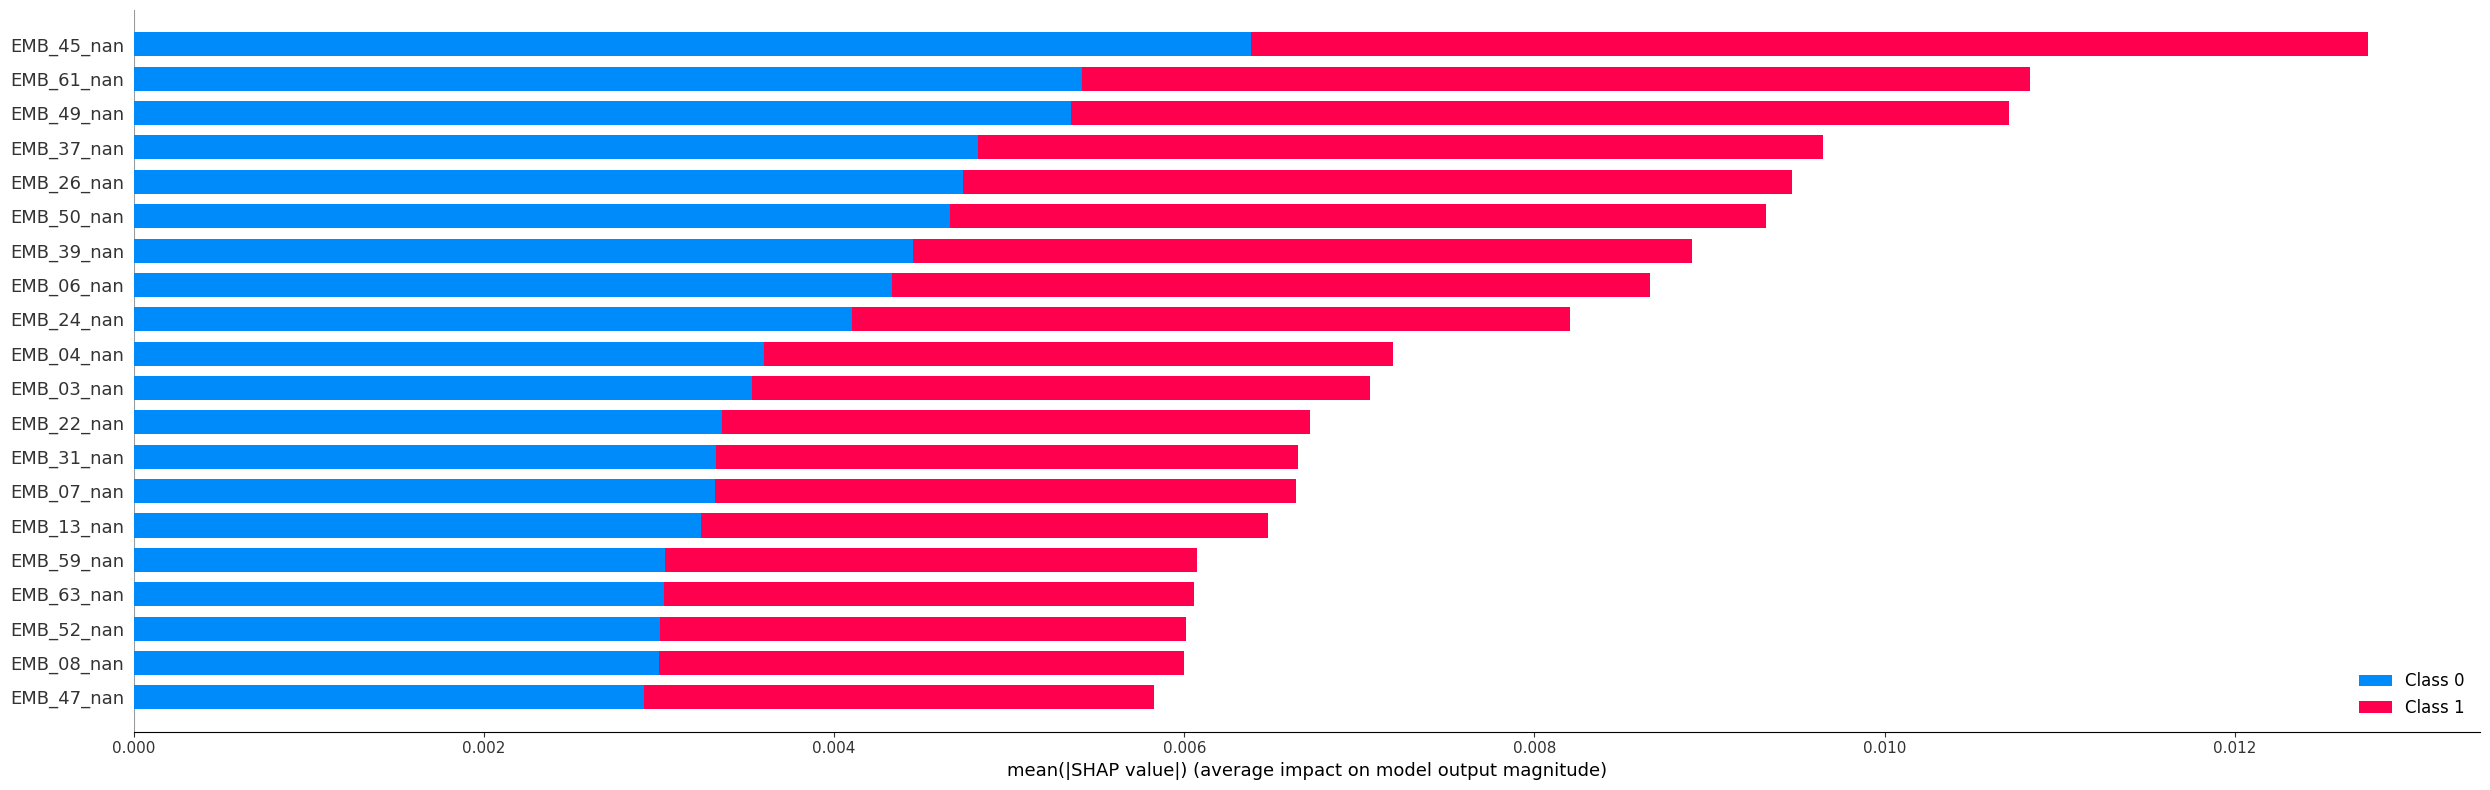

In [13]:
# asset 실행
train_asset_structure=run(step, pipeline, asset_structure)

# train asset의 결과 dataframe은 train_asset_structure.data['dataframe']으로 확인할 수 있습니다.
train_asset_structure.data['dataframe'].head(10)

<br>

## Inference workflow 
GCR의 Inference Workflow 구성은 다음과 같습니다.
1. Input : 사용자가 지정한 경로로부터 데이터를 Import
2. Preprocess : (필요시) 결측치 처리 및 라벨 인코딩
3. Inference : Train Workflow에서 선택된 베스트 모델을 활용해 라벨 추론
4. Result : 결과 출력

아래 코드를 실행하여 Train Workflow에 필요한 라이브러리를 먼저 설치 해주세요.

In [42]:
# 아래는 Inference 시 필요한 라이브러리를 설치하는 코드입니다. library 설치 에러가 발생하면 아래 셀을 재실행 해주세요
external_load_data(pipelines[1], alo.external_path, alo.external_path_permission, alo.control['get_external_data'])
pipeline = pipelines[1]
alo.install_steps(pipeline, alo.control["get_asset_source"])

# 초기 data structure 구성
envs, args, data, config = {}, {}, {}, {}
init_asset_structure = AssetStructure(envs, args, data, config)
# logger init
alo.set_proc_logger()

[2023-11-15 12:18:40,694][PROCESS][INFO]: You did not write any << s3_private_key_file >> in the config yaml file. When you wanna get data from s3 storage, 
                                 you have to write the s3_private_key_file path or set << ACCESS_KEY, SECRET_KEY >> in your os environment. 

[2023-11-15 12:18:40,700][PROCESS][INFO]: Start setting-up << input >> asset @ << assets >> directory.
[2023-11-15 12:18:40,703][PROCESS][INFO]: Now << local >> asset_source_code mode: <input> asset exists.
[2023-11-15 12:18:40,706][PROCESS][INFO]: Start setting-up << preprocess >> asset @ << assets >> directory.
[2023-11-15 12:18:40,708][PROCESS][INFO]: Now << local >> asset_source_code mode: <preprocess> asset exists.
[2023-11-15 12:18:40,710][PROCESS][INFO]: Start setting-up << inference >> asset @ << assets >> directory.
[2023-11-15 12:18:40,713][PROCESS][INFO]: << inference >> asset had already been created at 2023-11-15 10:16:25.756357
[2023-11-15 12:18:40,716][PROCESS][INFO]: Start set

### 0. Input asset 
#### 주요 Parameter
- *input_path : GCR에서는 추론데이터가 'inference' 위치에 자동 저장됩니다. 따로 설정할 필요 없이 주어진 'inference'로 놓고 사용합니다.
- x_columns : Inference workflow에서는 x_column을 따로 지정하지 않습니다. None으로 설정합니다.
- *use_all_x : Inference workflow에서는 use_all_x를 True로 놓습니다.
- y_column : 추론데이터는 y_column이 없습니다. None으로 설정합니다.

In [16]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - preprocess(1) - inference(2) - result(3))
step = 0 
asset_structure = copy.deepcopy(init_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 input asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['x_columns'] = ['']
asset_structure.args

{'input_path': 'inference',
 'x_columns': None,
 'use_all_x': True,
 'y_column': None,
 'groupkey_columns': None,
 'drop_columns': None,
 'time_column': None,
 'concat_dataframes': None,
 'encoding': None}

##### Input asset 실행 

In [17]:
# asset 실행
input_asset_structure=run(step, pipeline, asset_structure)

# input asset의 결과 dataframe은 input_asset_structure.data['dataframe']으로 확인할 수 있습니다.
input_asset_structure.data['dataframe'].head(10)

[2023-11-15 10:16:25,646][USER][INFO][inference_pipeline][input]: >> Load path : ['/home/jovyan/gcr_dev/alo/input/inference/inference/']
[2023-11-15 10:16:25,657][USER][INFO][inference_pipeline][input]: >> The file for batch data has been loaded. (File name: /home/jovyan/gcr_dev/alo/input/inference/inference/inference.csv)
[2023-11-15 10:16:25,660][USER][INFO][inference_pipeline][input]: You set the << use_all_x >> as << True >> in the yaml file. So skip checking dataframe columns existence.
[2023-11-15 10:16:25,663][USER][INFO][inference_pipeline][input]: ==================== Success loading dataframe ====================
[2023-11-15 10:16:25,666][USER][INFO][inference_pipeline][input]: >> Start processing ignore columns & drop columns: ['/home/jovyan/gcr_dev/alo/input/inference/inference/inference.csv']
[2023-11-15 10:16:25,670][USER][INFO][inference_pipeline][input]: >> You set the << use_all_x >> parameter as << True >> in your config yaml. (So, these x_columns are used: ['EMB_62',

[2023-11-15 10:16:25,642][ASSET][INFO][inference_pipeline][input]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-15 10:16:25
- current step      : input
- asset branch.     : tabular_2.0
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path'])
- load args. keys   : dict_keys(['input_path', 'x_columns', 'use_all_x', 'y_column', 'groupkey_columns', 'drop_columns', 'time_column', 'concat_dataframes', 'encoding'])
- load config. keys : dict_keys(['meta'])
- load data keys    : dict_keys([])


[2023-11-15 10:16:25,671][ASSET][INFO][inference_pipeline][input]: 

============================= ASSET FINISH ===========================
- time (UTC)        : 2023-11-15 10:16:25
- current step      : input
- save config. key

,EMB_00,EMB_01,EMB_02,EMB_03,EMB_04,EMB_05,EMB_06,EMB_07,EMB_08,EMB_09,...,EMB_54,EMB_55,EMB_56,EMB_57,EMB_58,EMB_59,EMB_60,EMB_61,EMB_62,EMB_63
0,0.005414,-0.001414,-0.001504,0.012186,0.005871,-0.002538,0.007031,0.001438,0.004546,-0.012055,...,0.004200,-0.009254,-0.005421,0.008268,0.011973,-0.006837,0.003715,-0.012994,0.000196,0.006311
1,0.002558,0.012455,-0.002922,0.006427,0.008360,-0.007265,0.002146,-0.008540,-0.007959,0.009944,...,0.016557,-0.021171,0.001721,0.007369,0.000753,-0.003986,0.014472,-0.002204,-0.023196,0.000223
2,0.001795,0.027199,-0.002865,-0.004055,-0.003229,0.027128,-0.007764,0.014579,-0.011088,-0.005998,...,-0.000122,-0.027237,0.002930,0.017666,-0.020329,0.010877,0.025670,0.015895,0.001505,-0.008467
3,-0.010353,-0.001605,-0.002123,0.004019,0.016011,-0.012714,0.009503,-0.010463,-0.008563,0.019467,...,-0.003271,-0.010024,0.001952,0.017236,0.000463,-0.004881,-0.002048,0.002250,-0.006697,0.016579
4,0.015729,-0.004807,-0.000182,0.007917,0.017711,0.038704,0.005745,0.000413,0.010579,0.004112,...,0.013575,-0.015005,-0.032511,-0.011125,0.001102,0.000403,0.021525,0.001062,-0.008668,0.020516
5,-0.017127,0.024546,-0.011373,0.011780,-0.015008,-0.035985,-0.004418,0.003619,0.017380,-0.020313,...,-0.012573,-0.017277,0.013202,0.029550,0.014711,0.026671,-0.016550,0.035736,-0.015332,-0.007625
6,0.009031,0.012920,0.003261,-0.009855,0.012314,-0.017714,-0.024314,-0.002422,-0.014871,0.022444,...,-0.008524,0.020048,-0.015424,-0.001511,-0.002701,-0.000331,0.002000,0.017088,-0.010794,0.002108
7,0.047938,0.021478,0.014271,0.017225,-0.005911,-0.009691,-0.023102,0.002689,-0.017652,0.025938,...,-0.032887,-0.003750,0.006039,0.002796,-0.025264,0.005336,0.003164,0.012031,-0.016678,0.002014
8,-0.010277,-0.012224,0.030582,-0.008301,0.008208,0.017006,0.012763,-0.003090,0.005644,0.022367,...,-0.023069,0.015431,-0.010737,0.019173,-0.020052,-0.013143,0.000196,-0.018340,0.000921,0.027325
9,-0.013013,0.000820,-0.006603,0.000225,0.020575,-0.015420,0.010655,-0.017540,-0.005734,0.015409,...,-0.007585,-0.005575,-0.002974,0.009368,0.002496,-0.001832,-0.005721,0.000963,-0.005290,0.014835


</br>

### 1. Preprocess asset 
GCR은 데이터 전처리가 불필요하기 때문에 Preprocess asset의 역할은 크지 않습니다. 다만 사용자가 임베딩 외에 raw data를 학습에 사용하는 경우 (즉, extra_columns_for_ml 설정시) 결측치를 처리하기 위한 용도입니다.
#### 주요 Parameter
- handling_missing: 결측치 처리 방식을 지정합니다. 'interpolation' 또는 'fill_number' 중에 선택할 수 있으며 GCR에서는 'interpolation'을 권장합니다.
- *handling_encoding_y_column: input asset의 y_column과 동일하게 설정합니다. (필수)

In [18]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - preprocess(1) - inference(2) - result(3))
step = 1 
asset_structure = copy.deepcopy(input_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 preprocess asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['x_columns'] = ['']
asset_structure.args

{'handling_missing': 'interpolation',
 'handling_encoding_y_column': None,
 'limit_encoding_categories': 30,
 'load_train_preprocess': True}

##### Preprocess asset 실행 

In [19]:
# asset 실행
preprocess_asset_structure=run(step, pipeline, asset_structure)

# preprocess asset의 결과 dataframe은 preprocess_asset_structure.data['dataframe']으로 확인할 수 있습니다.  
preprocess_asset_structure.data['dataframe'].head(10)

[2023-11-15 10:16:25,710][ASSET][INFO][inference_pipeline][preprocess]: Successfully got model path for saving or loading your AI model: 
 /home/jovyan/gcr_dev/alo/.train_artifacts/models/preprocess/
[2023-11-15 10:16:25,712][ASSET][INFO][inference_pipeline][preprocess]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-15 10:16:25
- current step      : preprocess
- asset branch.     : release-1.2
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['handling_missing', 'handling_encoding_y_column', 'limit_encoding_categories', 'load_train_preprocess'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path',

,EMB_62,EMB_43,EMB_14,EMB_31,EMB_38,EMB_54,EMB_50,EMB_60,EMB_51,EMB_02,...,EMB_04_nan,EMB_06_nan,EMB_27_nan,EMB_08_nan,EMB_41_nan,EMB_35_nan,EMB_01_nan,EMB_63_nan,EMB_18_nan,EMB_59_nan
0,0.000196,0.011611,0.010256,-0.002353,-0.006461,0.004200,-0.009528,0.003715,-0.005716,-0.001504,...,0.005871,0.007031,-0.018411,0.004546,0.021116,-0.005868,-0.001414,0.006311,-0.007431,-0.006837
1,-0.023196,-0.001093,-0.017425,0.003496,-0.009400,0.016557,0.008686,0.014472,0.006627,-0.002922,...,0.008360,0.002146,-0.011488,-0.007959,-0.004343,-0.002364,0.012455,0.000223,-0.002865,-0.003986
2,0.001505,0.008165,0.012083,-0.012214,0.006523,-0.000122,-0.002292,0.025670,0.010234,-0.002865,...,-0.003229,-0.007764,-0.020970,-0.011088,-0.008415,-0.016358,0.027199,-0.008467,-0.018428,0.010877
3,-0.006697,-0.020988,-0.009581,-0.001076,-0.012396,-0.003271,0.009289,-0.002048,-0.010167,-0.002123,...,0.016011,0.009503,0.008207,-0.008563,0.017410,0.010789,-0.001605,0.016579,0.000986,-0.004881
4,-0.008668,-0.013330,0.014066,-0.018598,0.011340,0.013575,0.009422,0.021525,0.022600,-0.000182,...,0.017711,0.005745,0.006702,0.010579,-0.031473,0.005961,-0.004807,0.020516,-0.013745,0.000403
5,-0.015332,0.018338,0.003890,0.021785,-0.010227,-0.012573,0.006438,-0.016550,-0.025950,-0.011373,...,-0.015008,-0.004418,-0.011600,0.017380,-0.007034,0.008936,0.024546,-0.007625,-0.020536,0.026671
6,-0.010794,-0.001457,-0.004939,0.016416,0.011705,-0.008524,-0.013296,0.002000,0.009023,0.003261,...,0.012314,-0.024314,-0.012192,-0.014871,-0.004951,-0.003598,0.012920,0.002108,-0.004750,-0.000331
7,-0.016678,0.001108,0.014526,0.021897,-0.014345,-0.032887,0.000184,0.003164,0.011486,0.014271,...,-0.005911,-0.023102,-0.006162,-0.017652,0.003110,0.000152,0.021478,0.002014,-0.006613,0.005336
8,0.000921,0.022632,-0.011128,-0.022184,0.005126,-0.023069,-0.028725,0.000196,0.003828,0.030582,...,0.008208,0.012763,-0.024520,0.005644,-0.043829,0.020047,-0.012224,0.027325,0.017989,-0.013143
9,-0.005290,-0.018874,-0.008214,-0.006472,-0.008163,-0.007585,0.009757,-0.005721,-0.010411,-0.006603,...,0.020575,0.010655,0.003212,-0.005734,0.016677,0.009014,0.000820,0.014835,-0.002253,-0.001832


<br>

### 2. Inference asset 

#### 주요 Parameter
- model_type: Train workflow의 Train asset과 동일하게 classification/regression 중 설정하면 됩니다.

In [20]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - preprocess(1) - inference(2) - result(3))
step = 2 
asset_structure = copy.deepcopy(preprocess_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 inference asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['x_columns'] = ['']
asset_structure.args

{'model_type': 'classification', 'run_shapley': False}

##### inference asset 실행 

In [21]:
# asset 실행
inference_asset_structure=run(step, pipeline, asset_structure)

# inference asset의 결과 dataframe은 inference_asset_structure.data['dataframe']으로 확인할 수 있습니다.  
inference_asset_structure.data['dataframe'].head(10)


 ################################### inference_init (sec):  0.0001595020294189453 ################################### 

[2023-11-15 10:16:25,782][ASSET][INFO][inference_pipeline][inference]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-15 10:16:25
- current step      : inference
- asset branch.     : tcr_v1.1.2
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['model_type', 'run_shapley'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns', 'columns_map', 'preprocess'])
- load data keys    : dict_keys(['dataframe'])

,EMB_00,EMB_01,EMB_02,EMB_03,EMB_04,EMB_05,EMB_06,EMB_07,EMB_08,EMB_09,...,EMB_59_nan,EMB_60_nan,EMB_61_nan,EMB_62_nan,EMB_63_nan,train_test,pred_,prediction_score,prob_0,prob_1
0,0.005414,-0.001414,-0.001504,0.012186,0.005871,-0.002538,0.007031,0.001438,0.004546,-0.012055,...,-0.006837,0.003715,-0.012994,0.000196,0.006311,test,0,"[0.6719129985390637, 0.328087001460936]",0.671913,0.328087
1,0.002558,0.012455,-0.002922,0.006427,0.008360,-0.007265,0.002146,-0.008540,-0.007959,0.009944,...,-0.003986,0.014472,-0.002204,-0.023196,0.000223,test,0,"[0.6739091426774176, 0.32609085732258253]",0.673909,0.326091
2,0.001795,0.027199,-0.002865,-0.004055,-0.003229,0.027128,-0.007764,0.014579,-0.011088,-0.005998,...,0.010877,0.025670,0.015895,0.001505,-0.008467,test,0,"[0.658143786838848, 0.3418562131611526]",0.658144,0.341856
3,-0.010353,-0.001605,-0.002123,0.004019,0.016011,-0.012714,0.009503,-0.010463,-0.008563,0.019467,...,-0.004881,-0.002048,0.002250,-0.006697,0.016579,test,0,"[0.6681796643846966, 0.3318203356153041]",0.668180,0.331820
4,0.015729,-0.004807,-0.000182,0.007917,0.017711,0.038704,0.005745,0.000413,0.010579,0.004112,...,0.000403,0.021525,0.001062,-0.008668,0.020516,test,0,"[0.6655546987596799, 0.33444530124031996]",0.665555,0.334445
5,-0.017127,0.024546,-0.011373,0.011780,-0.015008,-0.035985,-0.004418,0.003619,0.017380,-0.020313,...,0.026671,-0.016550,0.035736,-0.015332,-0.007625,test,0,"[0.703166737845915, 0.29683326215408584]",0.703167,0.296833
6,0.009031,0.012920,0.003261,-0.009855,0.012314,-0.017714,-0.024314,-0.002422,-0.014871,0.022444,...,-0.000331,0.002000,0.017088,-0.010794,0.002108,test,0,"[0.634744749008124, 0.36525525099187556]",0.634745,0.365255
7,0.047938,0.021478,0.014271,0.017225,-0.005911,-0.009691,-0.023102,0.002689,-0.017652,0.025938,...,0.005336,0.003164,0.012031,-0.016678,0.002014,test,0,"[0.7378133431871043, 0.2621866568128956]",0.737813,0.262187
8,-0.010277,-0.012224,0.030582,-0.008301,0.008208,0.017006,0.012763,-0.003090,0.005644,0.022367,...,-0.013143,0.000196,-0.018340,0.000921,0.027325,test,0,"[0.6468732843442787, 0.3531267156557213]",0.646873,0.353127
9,-0.013013,0.000820,-0.006603,0.000225,0.020575,-0.015420,0.010655,-0.017540,-0.005734,0.015409,...,-0.001832,-0.005721,0.000963,-0.005290,0.014835,test,0,"[0.6643872326971653, 0.3356127673028353]",0.664387,0.335613


In [22]:
inference_asset_structure.data['dataframe'].columns

Index(['EMB_00', 'EMB_01', 'EMB_02', 'EMB_03', 'EMB_04', 'EMB_05', 'EMB_06',
       'EMB_07', 'EMB_08', 'EMB_09',
       ...
       'EMB_59_nan', 'EMB_60_nan', 'EMB_61_nan', 'EMB_62_nan', 'EMB_63_nan',
       'train_test', 'pred_', 'prediction_score', 'prob_0', 'prob_1'],
      dtype='object', length=133)

<br>

### 3. Result asset 

#### 주요 Parameter
- result_save_name: 결과 저장 파일명을 설정합니다.

In [23]:
# GCR asset 순서에 따라 step 순서를 입력합니다. (input(0) - preprocess(1) - inference(2) - result(3))
step = 3
asset_structure = copy.deepcopy(inference_asset_structure)
asset_structure.args = alo.get_args(pipeline, step)

# 아래 주석을 풀어 result asset argument를 원하는 값으로 수정합니다.
# asset_structure.args['x_columns'] = ['']
asset_structure.args

{'result_save_name': None}

##### result asset 실행 

In [24]:
# asset 실행
result_asset_structure=run(step, pipeline, asset_structure)

# result asset의 결과 dataframe은 result_asset_structure.data['dataframe']으로 확인할 수 있습니다.
result_asset_structure.data['dataframe'].head(10)

[2023-11-15 10:16:25,978][ASSET][INFO][inference_pipeline][result]: 

============================= ASSET START =============================
- time (UTC)        : 2023-11-15 10:16:25
- current step      : result
- asset branch.     : release-1.2
- alolib ver.       : 2.0
- alo ver.          : release-2.0
- load envs. keys   : dict_keys(['project_home', 'pipeline', 'step', 'num_step', 'artifacts', 'alo_version', 'asset_branch', 'interface_mode', 'load_data', 'load_config', 'save_data', 'save_config', 'log_file_path', 'prev_step'])
- load args. keys   : dict_keys(['result_save_name'])
- load config. keys : dict_keys(['meta', 'data_source_type', 'time_format', 'time_column', 'x_columns', 'input_path', 'group_cnt', 'group_keys', 'y_column', 'input_asset_df_path', 'ignore_columns', 'columns_map', 'preprocess'])
- load data keys    : dict_keys(['dataframe'])


Loading Embeddings
[2023-11-15 10:16:25,980][ASSET][INFO][inference_pipeline][result]: Successfully got model path for saving or loa

,name,is_married,train_test,pred_,prediction_score,prob_0,prob_1
0,Gregory_Hull,NaN,test,0,"[0.6719129985390637, 0.328087001460936]",0.671913,0.328087
1,Allison_Peterson,NaN,test,0,"[0.6739091426774176, 0.32609085732258253]",0.673909,0.326091
2,Daniel_Davies,NaN,test,0,"[0.658143786838848, 0.3418562131611526]",0.658144,0.341856
3,Alison_Fox,NaN,test,0,"[0.6681796643846966, 0.3318203356153041]",0.668180,0.331820
4,Daniel_Moore,NaN,test,0,"[0.6655546987596799, 0.33444530124031996]",0.665555,0.334445
5,Barbara_Smith,NaN,test,0,"[0.703166737845915, 0.29683326215408584]",0.703167,0.296833
6,Paul_Terry,NaN,test,0,"[0.634744749008124, 0.36525525099187556]",0.634745,0.365255
7,Christina_Salas,NaN,test,0,"[0.7378133431871043, 0.2621866568128956]",0.737813,0.262187
8,Jose_Boyd,NaN,test,0,"[0.6468732843442787, 0.3531267156557213]",0.646873,0.353127
9,Zachary_Fowler,NaN,test,0,"[0.6643872326971653, 0.3356127673028353]",0.664387,0.335613
